In [1]:
!pip install transformers
!pip install datasets
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# file_path = '/content/drive/MyDrive/3-year SEDS/NLP_benchmark/ass4/Az_news_Sentiment_Emotion_2022.xlsx'
file_path = '/content/drive/My Drive/NLP_projects/Project_4/Az_news_Sentiment_Emotion_2022.xlsx'
#file_path = 'Az_news_Sentiment_Emotion_2022.xlsx'
df = pd.read_excel(file_path)
df.head()

,content,positive,negative,neutral,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,Dövlət Gömrük Komitəsi (DGK) Tovuz Gömrük İdar...,0,neg,0,NaN,NaN,NaN,NaN,NaN,sad,NaN,NaN
1,"Sabah, sentyabrın 22-də Bakıda və Abşeron yar...",0,0,neu,NaN,ant,NaN,NaN,NaN,NaN,NaN,NaN
2,Bakı. Samir Əli - Trend: Sentyabrın 20-də axş...,0,neg,0,NaN,NaN,NaN,fea,NaN,sad,NaN,NaN
3,Azərbaycan Respublikasının Prezidenti İlham Ə...,pos,0,0,NaN,NaN,NaN,NaN,joy,NaN,sur,NaN
4,Yexlax-Zaqatala-Gürcüstan sərhədi magistral yo...,pos,0,0,NaN,ant,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def get_sentiment(row):
    if row['positive'] == 'pos':
        return 'positive'
    elif row['negative'] == 'neg':
        return 'negative'
    elif row['neutral'] == 'neu':
        return 'neutral'
    else:
        return 'unknown'

df['sentiment'] = df.apply(get_sentiment, axis=1)
df = df[df['sentiment'] != 'unknown']  # remove unclear rows
df = df[['content', 'sentiment']]  # keep only needed columns
df.head()

,content,sentiment
0,Dövlət Gömrük Komitəsi (DGK) Tovuz Gömrük İdar...,negative
1,"Sabah, sentyabrın 22-də Bakıda və Abşeron yar...",neutral
2,Bakı. Samir Əli - Trend: Sentyabrın 20-də axş...,negative
3,Azərbaycan Respublikasının Prezidenti İlham Ə...,positive
4,Yexlax-Zaqatala-Gürcüstan sərhədi magistral yo...,positive


In [5]:
df = df.sample(frac=0.1).reset_index(drop=True)  # shuffle rows

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])  # e.g., 0=negative, 1=neutral, 2=positive

# Drop missing or non-string values in 'content'
df = df[df['content'].notna()]  # remove rows where content is NaN
df['content'] = df['content'].astype(str)  # force everything to string

# Now get the cleaned texts
texts = df['content'].tolist()
labels = df['label'].tolist()

In [7]:
from huggingface_hub import notebook_login

notebook_login()

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("allmalab/bert-tokenizer-aze")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/534k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

In [9]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Initialize tokenizer first
tokenizer = BertTokenizer.from_pretrained("allmalab/bert-base-aze")

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Now safely tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/534k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

In [10]:
import torch
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {"labels": torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)


In [11]:
train_dataset = SentimentDataset(train_encodings, train_labels)
eval_dataset = SentimentDataset(val_encodings, val_labels)

In [12]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained("allmalab/bert-base-aze", num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)



config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allmalab/bert-base-aze and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

# ✅ STEP 6: Train and Evaluate
trainer.train()

# ✅ STEP 7: Final evaluation (optional)
eval_results = trainer.evaluate()
print(eval_results)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jafarisbarov (ailab-az) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.636200,0.584192,0.742678,0.740618
2,0.545300,0.760009,0.748954,0.746033
3,0.196100,0.959662,0.734310,0.733131


{'eval_loss': 0.9596622586250305, 'eval_accuracy': 0.7343096234309623, 'eval_f1': 0.7331306410429096, 'eval_runtime': 3.5801, 'eval_samples_per_second': 133.515, 'eval_steps_per_second': 16.759, 'epoch': 3.0}


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [16]:
# Get predictions
preds_output = trainer.predict(eval_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

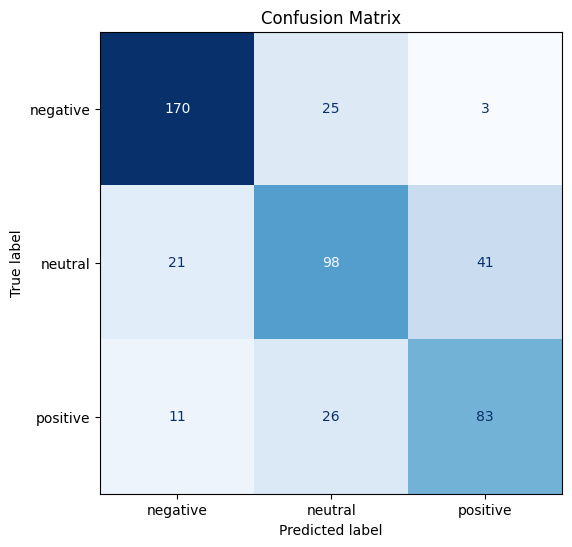

In [17]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix")
plt.show()


In [18]:
report = classification_report(y_true, y_pred, target_names=le.classes_)
print(report)


              precision    recall  f1-score   support

    negative       0.84      0.86      0.85       198
     neutral       0.66      0.61      0.63       160
    positive       0.65      0.69      0.67       120

    accuracy                           0.73       478
   macro avg       0.72      0.72      0.72       478
weighted avg       0.73      0.73      0.73       478

